In [1]:
%%capture
!pip install unsloth vllm

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
from unsloth import FastLanguageModel, PatchFastRL
PatchFastRL("GRPO", FastLanguageModel)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-09-27 01:15:10.103284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758935710.310566      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758935710.370115      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


INFO 09-27 01:15:32 [__init__.py:216] Automatically detected platform cuda.
ERROR 09-27 01:15:33 [fa_utils.py:57] Cannot use FA version 2 is not supported due to FA2 is only supported on devices with compute capability >= 8
🦥 Unsloth Zoo will now patch everything to make training faster!


In [4]:
from unsloth import is_bfloat16_supported
import torch
max_seq_length = 512 
lora_rank = 32 

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "google/gemma-3-270m-it",
    max_seq_length = max_seq_length,
    load_in_4bit = False, 
    load_in_8bit = True,
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.6, 
)

==((====))==  Unsloth 2025.9.9: Fast Gemma3 patching. Transformers: 4.56.2. vLLM: 0.10.2.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

In [5]:
model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, 
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ], 
    lora_alpha = lora_rank,
    use_gradient_checkpointing = "unsloth", 
    random_state = 3407,
)

Unsloth: Making `model.base_model.model.model` require gradients


In [6]:
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

XML_COT_FORMAT = """\
<reasoning>
{reasoning}
</reasoning>
<answer>
{answer}
</answer>
"""

In [7]:
import re
from datasets import load_dataset, Dataset

In [8]:
def extract_xml_answer(text: str) -> str:
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()

def extract_hash_answer(text: str) -> str | None:
    if "####" not in text:
        return None
    return text.split("####")[1].strip()

In [9]:
def get_gsm8k_questions(split = "train") -> Dataset:
    data = load_dataset('openai/gsm8k', 'main')[split] 
    data = data.map(lambda x: { 
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['question']}
        ],
        'answer': extract_hash_answer(x['answer'])
    }) 
    return data 

In [10]:
dataset = get_gsm8k_questions()

README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

In [11]:
def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    q = prompts[0][-1]['content']
    extracted_responses = [extract_xml_answer(r) for r in responses]
    print('-'*20, f"Question:\n{q}", f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}")
    return [2.0 if r == a else 0.0 for r, a in zip(extracted_responses, answer)]

def int_reward_func(completions, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    return [0.5 if r.isdigit() else 0.0 for r in extracted_responses]

def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def count_xml(text) -> float:
    count = 0.0
    if text.count("<reasoning>\n") == 1:
        count += 0.125
    if text.count("\n</reasoning>\n") == 1:
        count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        count -= len(text.split("\n</answer>\n")[-1])*0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        count -= (len(text.split("\n</answer>")[-1]) - 1)*0.001
    return count

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    contents = [completion[0]["content"] for completion in completions]
    return [count_xml(c) for c in contents]

In [12]:
from trl import GRPOConfig, GRPOTrainer
training_args = GRPOConfig(
    learning_rate = 5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "paged_adamw_8bit",
    logging_steps = 1,
    bf16 = is_bfloat16_supported(),
    fp16 = not is_bfloat16_supported(),
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 1, 
    num_generations = 6, 
    max_prompt_length = 256,
    max_completion_length = 200,
    max_steps = 200,
    save_steps = 200,
    max_grad_norm = 0.1,
    report_to = "none", 
    output_dir = "outputs",
)

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 6


In [13]:
trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
        int_reward_func,
        correctness_reward_func,
    ],
    args = training_args,
    train_dataset = dataset,
)

Unsloth: Switching to float32 training since model cannot work with float16


In [14]:
train_output = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 7,473 | Num Epochs = 1 | Total steps = 200
O^O/ \_/ \    Batch size per device = 6 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (6 x 1 x 1) = 6
 "-____-"     Trainable parameters = 7,593,984 of 275,692,160 (2.75% trained)
`generation_config` default values have been modified to match model-specific defaults: {'max_length': 32768, 'top_p': 0.95}. If this is not desired, please set these values explicitly.


-------------------- Question:
A concert ticket costs $40. Mr. Benson bought 12 tickets and received a 5% discount for every ticket bought that exceeds 10. How much did Mr. Benson pay in all? 
Answer:
476 
Response:
Let the cost of a concert ticket be $40.
Mr. Benson bought 12 tickets, so the total cost of the tickets is 12 * $40 = $480.
Mr. Benson received a 5% discount on the ticket price, so the discount amount is 5% of $480, which is 0.05 * $480 = $24.00.
The discounted price of the tickets is $480 - $24.00 = $456.00.

Therefore, Mr. Benson paid $456.00 in all.

The cost of 12 tickets is $480.
The discount is 5% of the ticket price, which is 0.05 * $480 = $24.00.
The discounted price of the tickets is $480 - $24. 
Extracted:
Let the cost of a concert ticket be $40.
Mr. Benson bought 12 tickets, so the total cost of the tickets is 12 * $40 = $480.
Mr. Benson received a 5% discount on the ticket price, so the discount amount is 5% of $480, which is 0.05 * $480 = $24.00.
The discounte

Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,sampling / sampling_logp_difference / mean,sampling / sampling_logp_difference / max,sampling / importance_sampling_ratio / min,sampling / importance_sampling_ratio / mean,sampling / importance_sampling_ratio / max,kl,rewards / xmlcount_reward_func / mean,rewards / xmlcount_reward_func / std,rewards / soft_format_reward_func / mean,rewards / soft_format_reward_func / std,rewards / strict_format_reward_func / mean,rewards / strict_format_reward_func / std,rewards / int_reward_func / mean,rewards / int_reward_func / std,rewards / correctness_reward_func / mean,rewards / correctness_reward_func / std
1,0.000000,0.000000,0.000000,110.500000,73.000000,200.000000,0.166667,92.599998,73.000000,132.000000,0,0,0,0,0,0.000158,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,-0.053500,0.202243,165.666672,122.000000,200.000000,0.500000,131.333344,122.000000,138.000000,No Log,No Log,No Log,No Log,No Log,0.000057,-0.053500,0.202243,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,-0.058167,0.168868,117.000000,98.000000,152.000000,0.000000,117.000000,98.000000,152.000000,No Log,No Log,No Log,No Log,No Log,0.000131,-0.058167,0.168868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,85.666672,71.000000,122.000000,0.000000,85.666672,71.000000,122.000000,No Log,No Log,No Log,No Log,No Log,0.000099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.020833,0.051031,23.333334,1.000000,35.000000,0.000000,23.333334,1.000000,35.000000,No Log,No Log,No Log,No Log,No Log,0.000201,0.020833,0.051031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,132.000000,89.000000,200.000000,0.166667,118.400002,89.000000,197.000000,No Log,No Log,No Log,No Log,No Log,0.000325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,200.000000,200.000000,200.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,72.333336,63.000000,95.000000,0.000000,72.333336,63.000000,95.000000,No Log,No Log,No Log,No Log,No Log,0.000280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,89.666672,64.000000,137.000000,0.000000,89.666672,64.000000,137.000000,No Log,No Log,No Log,No Log,No Log,0.001643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000,158.833344,120.000000,200.000000,0.166667,150.600006,120.000000,194.000000,No Log,No Log,No Log,No Log,No Log,0.002143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Unsloth: Will smartly offload gradients to save VRAM!
-------------------- Question:
Jane is trying to decide whether to buy a house or a trailer. A house costs $480,000 and a trailer costs $120,000. Each loan will be paid in monthly installments over 20 years. How much more is the monthly payment on the house compared to the trailer? 
Answer:
1500 
Response:
<reasoning>
To determine the difference in monthly payment, we need to calculate the total cost of the house and the total cost of the trailer. The total cost of the house is $480,000 and the total cost of the trailer is $120,000.
The total cost of the house is $480,000.
The total cost of the trailer is $120,000.
The difference in the total cost is $480,000 - $120,000 = $360,000.
The monthly payment on the house is $480,000 / 12 = $40,000.
The monthly payment on the trailer is $120,000 / 12 = $10,000.
The difference in the monthly payment on the house 
Extracted:
<reasoning>
To determine the difference in monthly payment, we need 

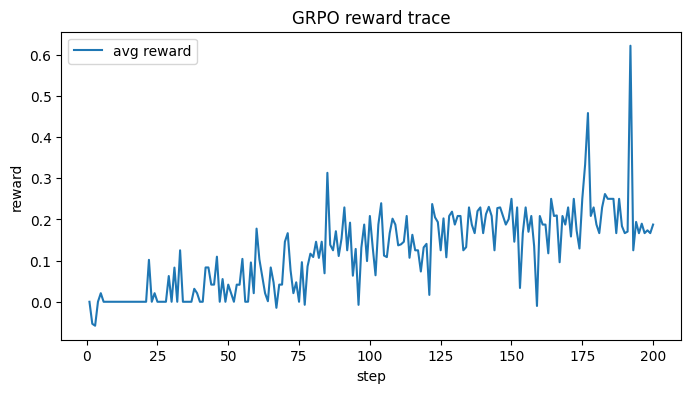

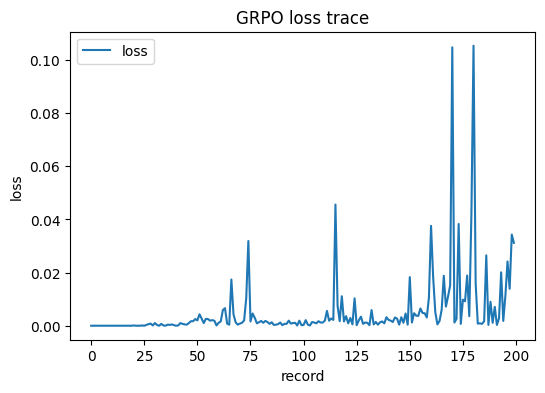

In [16]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history  
steps = []
avg_rewards = []
losses = []
for entry in logs:
    if "step" in entry and "reward" in entry:
        steps.append(entry["step"])
        avg_rewards.append(entry["reward"])
    if "step" in entry and "loss" in entry:
        losses.append(entry["loss"])

if avg_rewards:
    plt.figure(figsize=(8,4))
    plt.plot(steps, avg_rewards, label="avg reward")
    plt.xlabel("step")
    plt.ylabel("reward")
    plt.title("GRPO reward trace")
    plt.legend()
    plt.savefig("grpo_rewards.png")
    plt.show()

if losses:
    plt.figure(figsize=(6,4))
    plt.plot(losses, label="loss")
    plt.xlabel("record")
    plt.ylabel("loss")
    plt.title("GRPO loss trace")
    plt.legend()
    plt.savefig("grpo_loss.png")
    plt.show()

In [19]:
model.save_pretrained_merged("gsmma-270m-grpo", tokenizer, save_method = "merged_16bit")
model.push_to_hub_merged("Swekerr/gsmma-270m-grpo", tokenizer, save_method = "merged_16bit")

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Successfully copied all 1 files from cache to gsmma-270m-grpo.


Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


Unsloth: Merge process complete.


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Successfully copied all 1 files from cache to Swekerr/gsmma-270m-grpo.


Unsloth: Merging weights into 16bit:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [00:12<00:00, 12.45s/it]


Unsloth: Merge process complete.
